In [2]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community
from itertools import combinations
import networkx.algorithms.community as nx_comm
import re

df1 = pd.read_pickle("networkData1.pkl")
df2 = pd.read_pickle("networkData2.pkl")
df3 = pd.read_pickle("networkData3.pkl")

frames = [df1, df2, df3]
moviesDf = pd.concat(frames)

In [9]:
genres = (moviesDf['Genres'].to_numpy())
rating_column = moviesDf['Rating'].to_numpy()

In [10]:
genre_column = [re.findall(r"'name': '(.*?)'}", s) for s in genres]
title_column = moviesDf["MovieTitle"].to_numpy()
actor_column = list(moviesDf["Actors"].to_numpy())
G = nx.Graph()
G.add_nodes_from(title_column)


for i, title in enumerate(title_column):
    #actorsMain = set(actor_column[i])
    actorsMain = set(actor_column[i][:5])
    
    for j, cast in enumerate(actor_column[i+1:]):
        #actorsCompare = set(cast)
        actorsCompare = set(cast[:5])
        titleCompare = title_column[j]
        actorCommon = actorsMain & actorsCompare
        if(bool(actorCommon)):
            #print(title, titleCompare)
            #print(f'{list(actorsMain)}\n{list(actorsCompare)}\n')
            numberActorsCommon = len(actorCommon)
            #print(numberActorsCommon)
            G.add_edge(title, titleCompare, weight=numberActorsCommon)

In [11]:
# Extracting largest connected component
nodes = max(nx.connected_components(G), key=len)
G = G.subgraph(nodes).copy()

print(f'Stats before removing weakly connected nodes')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}\n')

# Removing nodes with very small degree
#remove = [node for node,degree in dict(G.degree()).items() if degree < 6]
#G.remove_nodes_from(remove)
      
print(f'Stats after removing weakly connected nodes')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}')

Stats before removing weakly connected nodes
Nodes: 5868
Edges: 74897

Stats after removing weakly connected nodes
Nodes: 5868
Edges: 74897


In [12]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

BarnesHut Approximation  took  2.99  seconds
Repulsion forces  took  40.19  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


In [13]:
d = dict(G.degree).values()
scale = 4
node_size = [degree*scale for degree in d]
node_size

[1368,
 792,
 740,
 444,
 504,
 664,
 564,
 296,
 220,
 324,
 356,
 248,
 376,
 444,
 308,
 504,
 256,
 240,
 228,
 304,
 500,
 376,
 352,
 316,
 300,
 260,
 380,
 132,
 172,
 148,
 208,
 252,
 260,
 208,
 240,
 316,
 132,
 192,
 192,
 228,
 188,
 156,
 348,
 144,
 328,
 228,
 288,
 192,
 136,
 392,
 88,
 124,
 140,
 148,
 224,
 112,
 364,
 148,
 152,
 136,
 308,
 288,
 108,
 316,
 124,
 136,
 256,
 128,
 220,
 304,
 192,
 116,
 92,
 248,
 296,
 136,
 132,
 340,
 384,
 84,
 304,
 80,
 160,
 124,
 184,
 248,
 264,
 252,
 284,
 184,
 268,
 224,
 280,
 380,
 148,
 120,
 220,
 84,
 396,
 144,
 304,
 356,
 256,
 320,
 96,
 208,
 132,
 136,
 136,
 124,
 136,
 364,
 184,
 176,
 224,
 88,
 252,
 292,
 236,
 116,
 300,
 136,
 116,
 316,
 164,
 84,
 108,
 296,
 104,
 196,
 256,
 120,
 100,
 268,
 164,
 124,
 220,
 148,
 348,
 436,
 248,
 136,
 80,
 160,
 188,
 196,
 216,
 424,
 380,
 292,
 336,
 208,
 232,
 128,
 316,
 204,
 384,
 208,
 384,
 144,
 320,
 348,
 284,
 128,
 192,
 292,
 144,
 272,


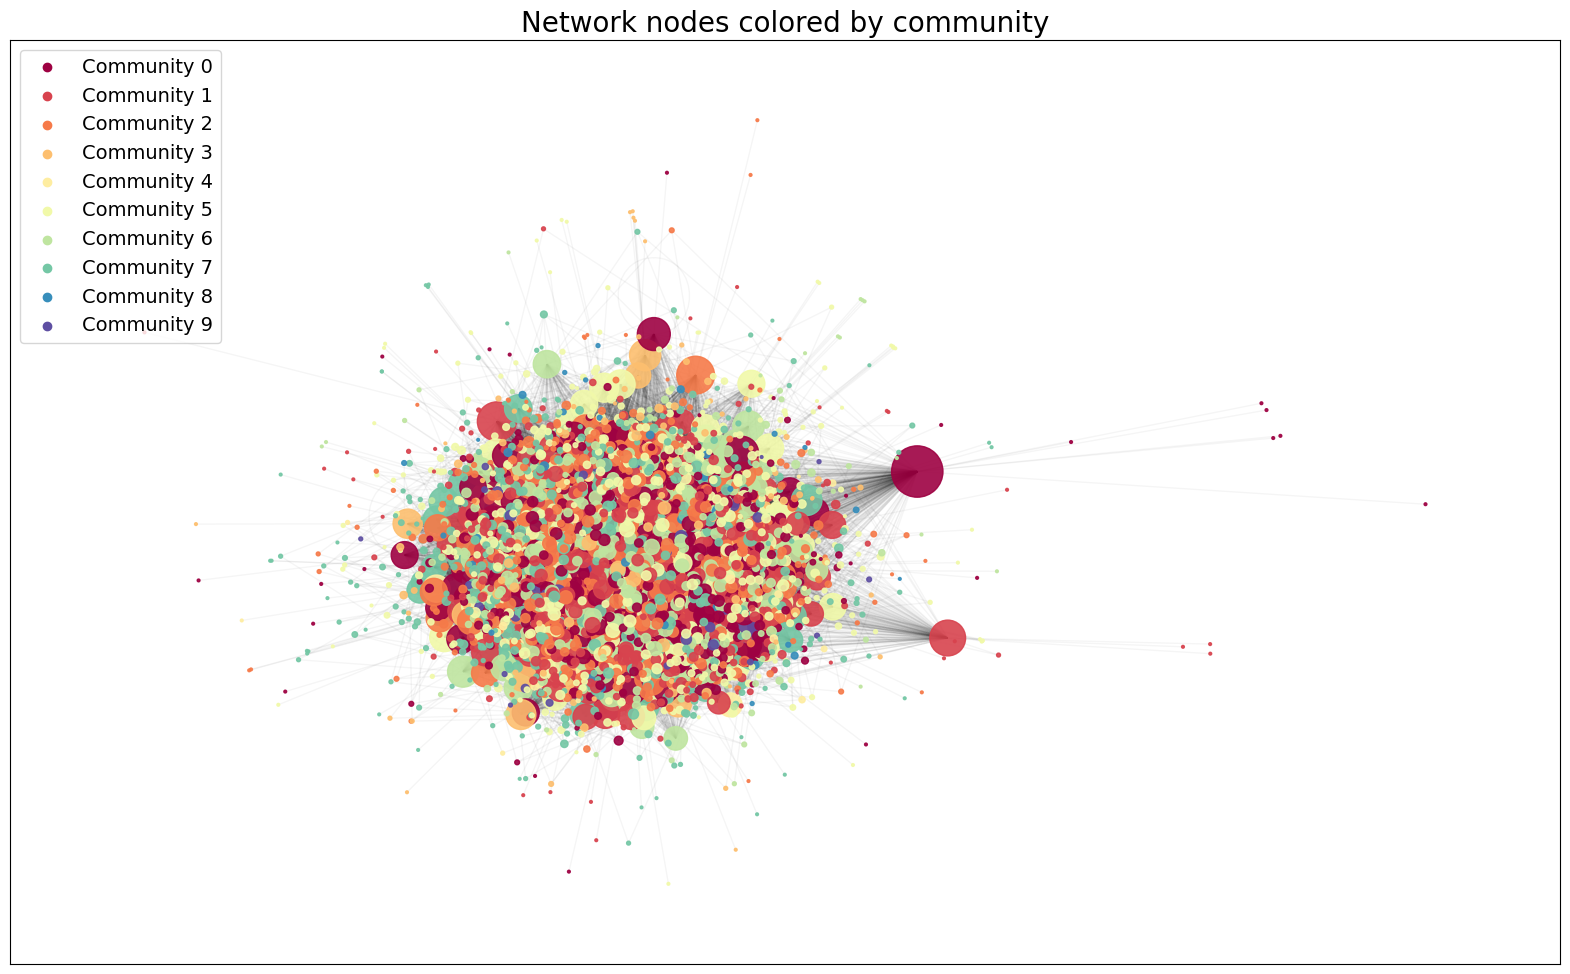

In [14]:
# Best partition found with louvain algorithm
partition = community.best_partition(G, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

# Plotting
plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(G, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(G, pos = positions, alpha=0.04);

# For legend creation only
for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.show()

ValueError: s must be a scalar, or float array-like with the same size as x and y

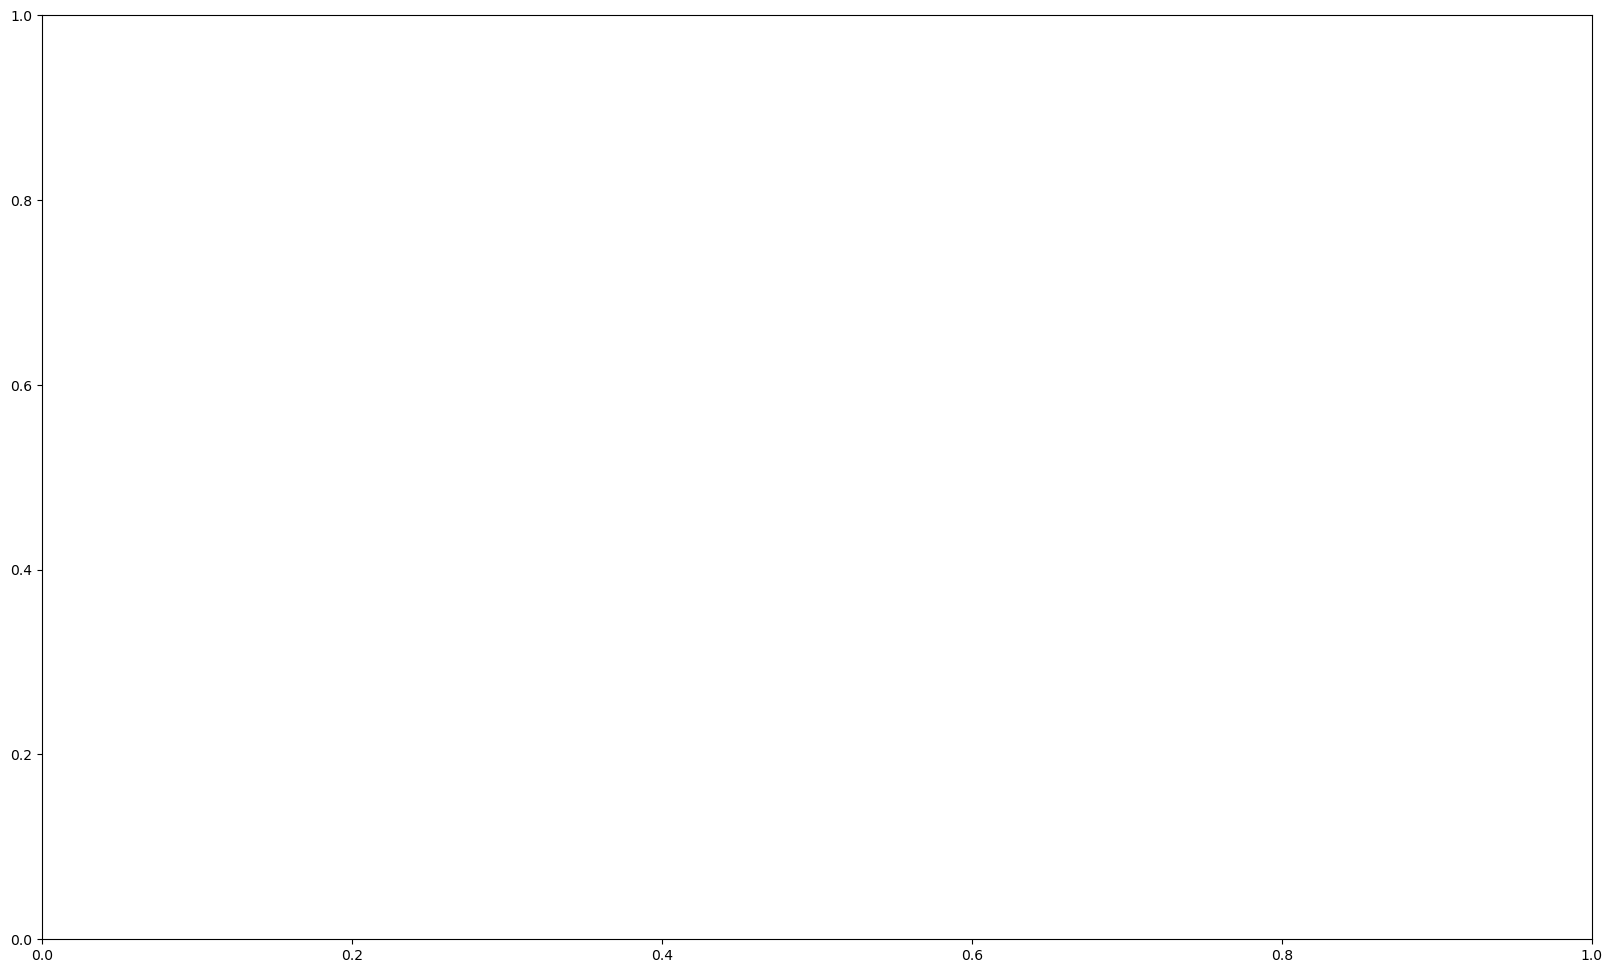

In [15]:
# With or without weights
communities = nx_comm.louvain_communities(G)#, weight = 'weight')

maxval = len(communities)
cmap=plt.cm.Spectral

plt.figure(1,figsize=(20,12)) 
for i, nodes in enumerate(communities):
    nx.draw_networkx_nodes(G, pos = positions, node_size = node_size, nodelist=nodes, node_color = [cmap(i/maxval)]*len(nodes))#, node_color=)

#nx.draw_networkx_nodes(G, pos = positions, node_color=node_color, alpha=0.9, node_size = 60);
nx.draw_networkx_edges(G, pos = positions, alpha=0.04);

#For label creation
for i in range(0,len(communities)):
    plt.scatter([],[], c=[cmap(i/maxval)], label='Community {}'.format(i))
plt.title('Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})

plt.show()

In [16]:
modularity = nx.algorithms.community.modularity(G, communities)
print(modularity)

0.1680187989313817


In [17]:
# rearanging found partition
parts = []
for i in range(0, len(set(partition.values()))):
    parts.append([])
    
for actor, com in partition.items():
    parts[com].append(actor)

#sorting based on biggest communities
#parts.sort(key=len, reverse = True)

In [19]:
# Most connected actors
sorted(G.degree, key=lambda x: x[1], reverse=False)

[('Across 110th Street', 1),
 ('Forbidden Zone', 1),
 ('Caged Heat', 1),
 ("Mother's Day", 1),
 ('Le notti del terrore', 1),
 ('Resident Evil', 1),
 ('Kissing Jessica Stein', 1),
 ('Pauline & Paulette', 1),
 ('Spetters', 1),
 ('Tendres Cousines', 1),
 ('Mr. Sardonicus', 1),
 ('Panic Room', 1),
 ('No Such Thing', 1),
 ('Very Annie Mary', 1),
 ('羅生門', 1),
 ('The Watcher in the Woods', 1),
 ('Dogtown and Z-Boys', 1),
 ('Whore', 1),
 ('Летят журавли', 1),
 ('Nora', 1),
 ('Atanarjuat', 1),
 ('Juwanna Mann', 1),
 ('Faustrecht der Freiheit', 1),
 ('Fathom', 1),
 ('The Château', 1),
 ('رأی مخفی', 1),
 ('Hot Shots!', 1),
 ('Love and a Bullet', 1),
 ('À Nous la Liberté', 1),
 ('Swimfan', 1),
 ('Tesis', 1),
 ('Les Enfants du Siècle', 1),
 ('Igby Goes Down', 1),
 ('The Hills Have Eyes Part II', 1),
 ('The Lavender Hill Mob', 1),
 ('El hijo de la novia', 1),
 ('The Four Feathers', 1),
 ('Le fate ignoranti', 1),
 ('Bloody Sunday', 1),
 ('The Rocking Horse Winner', 1),
 ('Seance on a Wet Afternoon', 

In [ ]:
# Checking actors with degrees in given partition
G.degree(parts[3])

In [ ]:
G.edges()